In [1]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

import re
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer
from vowpalwabbit.sklearn_vw import VWClassifier, VW
import itertools
from sklearn.decomposition import NMF, TruncatedSVD

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from scipy.sparse import csr_matrix, hstack

In [116]:
def sparsematrix(X):
    row = []
    col = []
    data = []
    for r in range(X.shape[0]):
        row_counter = Counter(X[r])
        for site, num in row_counter.items():
            row.append(r)
            col.append(site)
            data.append(num)
    print "Sparse Matrix - rows:", X.shape[0], "columns:", len(set(col))
    return csr_matrix((data, (row, col)), shape=(X.shape[0], len(set(col))))[:,1:]


def sites_to_sparse_tfidf(train_data, test_data, target_col, session_length, label_encoder=False):
    train_test_df = pd.concat([train_data, test_data])
    train_index_full = list(train_data.index)
    train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]+["target"]].index)
    test_index_full = list(test_data.index)
    test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,session_length+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]].index)
    train_duplicates_mask = np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])
    test_duplicates_mask = np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])

    y = train_data[target_col]

    train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
    train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                                  for i in range(train_test_df_sites.shape[0])]

    tfidf = TfidfVectorizer(max_df=0.9).fit(train_test_df_sites_array) #TfidfVectorizer()
    X_train_test_sparse = tfidf.transform(train_test_df_sites_array)

    X_train_sparse = X_train_test_sparse[:len(train_data)]
    X_test_sparse = X_train_test_sparse[len(train_data):]
    
    sites_columns_num = X_train_test_sparse.shape[1]
    
    y_for_vw = None
    class_encoder = None
    if label_encoder:
        class_encoder = LabelEncoder().fit(y.astype('str'))
        y_for_vw = class_encoder.transform(y.astype('str')) + 1
    
    return [X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder, tfidf, \
             train_duplicates_mask, test_duplicates_mask]


def features_to_sparse(train_data, test_data, feature_cols):
    features_matrix = []
    for df in [train_data, test_data]:
        num_cols = 0
        data = []
        rows = []
        cols = []
        for label in feature_cols:
            if label in ["day_of_week", "daytime"]:
                coldata = list(df[[label]].values.T[0].astype('float') + 1)
            else:
                coldata = list(df[[label]].values.T[0].astype('float'))
            if len(data):
                data += coldata
            else:
                data = list(coldata)
            if len(cols):
                cols += [num_cols] * len(coldata)
            else:
                cols = [num_cols] * len(coldata)
            num_cols += 1
        rows = [r for r in range(df.shape[0])] * num_cols
        features = csr_matrix((data, (rows, cols)), shape=(df.shape[0], num_cols), dtype=float)
        features_matrix.append(features)
    return features_matrix


def calc_site_times_portions(train_data, test_data):
    site_times = [{},{}]
    count = 0
    for data in [train_data, test_data]:
        for r, row in data[:][range(0, 10)+range(20,30)].iterrows():
            rowdic = {}
            for c, s in [[c, 'site' + str(c)] for c in range(1,10)]:
                if row[s] == 0:
                    continue
                if row[s] in rowdic:
                    rowdic[int(row[s])] += row["time_diff"+str(c)]
                else:
                    rowdic[int(row[s])] = row["time_diff"+str(c)]
            site_times[count][r] = {}
            for site, time in rowdic.items():
                if len(rowdic) == 1:
                    site_times[count][r][int(site)] = 1.0
                    continue
                if time > 0:
                    site_times[count][r][int(site)] = round(float(time)/row["session_timespan"],3)
        count+=1
    return site_times

def site_times_to_sparse(sitetimes):
    row = []
    col = []
    data = []
    rowcount = 0
    for sitetime in sitetimes:
        for r, sites in sitetime.items():
            for site, p in sites.items():
                col.append(site)
                row.append(rowcount)
                data.append(p)
            rowcount+=1
    site_times_sparse = csr_matrix((data, (row, col)), shape=(len(sitetimes[0])+len(sitetimes[1]), max(col)+1), \
                                                                                              dtype=float)[:,1:]
    return site_times_sparse



def combine_sites_features_sparse(sites_train_sparse, features_train_sparse, \
                                  sites_test_sparse, features_test_sparse, \
                                  train_duplicates_mask, test_duplicates_mask, \
                                  train_site_times_sparse = None, test_site_times_sparse = None, \
                                train_sites_sequence=None, test_sites_sequence=None):
    if train_site_times_sparse is not None and test_site_times_sparse is not None:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse, \
                                 train_site_times_sparse, train_sites_sequence], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse, \
                                test_site_times_sparse, test_sites_sequence], dtype=float).tocsr()
    else:
        X_train_sparse = hstack([sites_train_sparse, features_train_sparse], dtype=float).tocsr()
        X_test_sparse = hstack([sites_test_sparse, features_test_sparse], dtype=float).tocsr()
        
    X_train_sparse = hstack([X_train_sparse, train_duplicates_mask], dtype=float).tocsr()
    X_test_sparse = hstack([X_test_sparse, test_duplicates_mask], dtype=float).tocsr() 
    return [X_train_sparse, X_test_sparse]


def sparse_matrix_to_vw(X_sparse_full, sites_columns_num, vocabulary, y=None, \
                        mark_duplicates=False, csoaa=False, predictions={}):
    sessions = {}
    used = {}
    prediction = {}
    day_of_week = {}
    start_hour = {}
    daytime = {}
    unique_sites = {}
    top30_portion = {}
    fb_portion = {}
    youtube_portion = {}
    bot30_portion = {}
    site_longest_time = {}
    session_timespan = {}
    sitetimes = {}
    sequence = {}
    
    X_sparse = X_sparse_full[:,:-1]
    
    add_features = True

    for r, c in zip(X_sparse.nonzero()[0], X_sparse.nonzero()[1]):
        if tuple([r,c]) not in used:
            used[tuple([r, c])] = 1
            if add_features:
                if c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("prediction"):
                    prediction[r] = " |aprediction {}:{}".format(int(X_sparse[r,c]), 100)
                    #prediction[r] = " |prediction:100 {}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("day_of_week"):
                    day_of_week[r] = " |bday_of_week {}".format(int(X_sparse[r,c]))
                    #day_of_week[r] = " day_of_week:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("start_hour"):
                    start_hour[r] = " |chour_start {}".format(int(X_sparse[r,c]))
                    #start_hour[r] = " start_hour:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("daytime"):
                    daytime[r] = " |dtime_of_day {}".format(int(X_sparse[r,c]))
                    #daytime[r] = " daytime:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("session_timespan"):
                    session_timespan[r] = " |jsession_timespan time:{}".format(int(X_sparse[r,c]))
                    #session_timespan[r] = " session_timespan:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("#unique_sites"):
                    unique_sites[r] = " unique_sites:{}".format(int(X_sparse[r,c]))
                    #unique_sites[r] = " unique_sites:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("site_longest_time"):
                    site_longest_time[r] = " |hsite_longest_time {}:{}".format(int(X_sparse[r,c]), 3)
                    #site_longest_time[r] = " site_longest_time:{}".format(int(X_sparse[r,c]))
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("top30_portion"):
                    top30_portion[r] = " top30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("bot30_portion"):
                    bot30_portion[r] = " bot30:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("fb_portion"):
                    fb_portion[r] = " facebook:{}".format(X_sparse[r,c])
                    continue
                elif c == X_sparse.shape[1] - 10 - len(mycolumns) - sites_columns_num + mycolumns.index("youtube_portion"):
                    youtube_portion[r] = " youtube:{}".format(X_sparse[r,c])
                    continue
                elif c >= X_sparse.shape[1] - 10:
                    if r not in sequence:
                        sequence[r] = " |ksequence " + \
              ' '.join(filter(lambda a: a != "0", X_sparse[r,-10:].todense().astype(int).astype(str).tolist()[0]))
                    continue
            if c < sites_columns_num: #X_sparse.shape[1] - len(mycolumns): 
                if r in sessions:
                    sessions[r] += " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                else:
                    if y is not None:
                        y_label = str(y[r])
                        if csoaa:
                            alllabels = []
                            if r in predictions:
                                #alllabels = [str(lbl) + ":2" for lbl in range(1,551)]
                                for lbl in sorted(predictions[r]):
                                    if lbl == y[r]:
                                        alllabels.append(str(y[r]) + ":0")
                                    else:
                                        alllabels.append(str(lbl) + ":1")
                                    
                            else:
                                alllabels = [str(lbl) + ":1" for lbl in range(1,551)]
                                alllabels[y[r]-1] = str(y[r]) + ":0"                           
                            y_label = ' '.join([str(pus) for pus in alllabels])
                        if int(X_sparse_full[r, -1]) and mark_duplicates: # duplicate row indicator
                            sessions[r] = y_label + ' 0.3' + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                        else:
                            sessions[r] = y_label + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
                    else:
                        if csoaa:
                            if r in predictions:
                                y_label = ' '.join([str(pus) for pus in sorted(predictions[r])])
                            else:
                                y_label = ' '.join([str(pus) for pus in range(1,551)])
                        else:
                            y_label = ""
                        sessions[r] = y_label + ' |site' + " {}:{}".format(int(vocabulary[c]), X_sparse[r,c])
            elif c > X_sparse.shape[1] - sites_columns_num and c < X_sparse.shape[1] - 10:
                if r in sitetimes:
                    sitetimes[r] += " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
                else:
                    sitetimes[r] = ' |isitetime' + " {}:{}".format(int(c - sites_columns_num - len(mycolumns)+1), float(X_sparse[r,c]))
        
    
    return {"sites": sessions, "prediction": prediction, "day_of_week": day_of_week, \
                      "start_hour": start_hour, "daytime": daytime, \
                     "unique_site": unique_sites, "top30_portion": top30_portion, \
                    "bot30_portion": bot30_portion, "fb_portion": fb_portion, \
                    "youtube_portion": youtube_portion, "site_longest_time": site_longest_time, \
                    "session_timespan": session_timespan, "sitetimes": sitetimes, "sequence": sequence}



def vw_to_file(sites, out_file, features={}, quiet=True):   
    vw_writer = open(out_file, 'w')
    final_vw = {}
    gen_features = []
    
    if not quiet:
        print "Features:", features.keys()
        
    for r in sorted(sites.keys()):
        final_vw[r] = sites[r] #+ " |features"
        for fname, feature in features.items():
            if fname in ["youtube_portion", "fb_portion", "top30_portion", "bot30_portion", \
                                         "unique_sites"] and r in feature:
                gen_features.append(feature[r])
                continue
            if r in feature:
                final_vw[r] += feature[r]        
            
        if len(gen_features):
            final_vw[r] += " |features"
            for gf in gen_features:
                final_vw[r] += gf
        gen_features = []
        
        #if "prediction" in features and r in features["prediction"]:
            #final_vw[r] += features["prediction"][r]
        
        vw_writer.write(final_vw[r] + "\n")
        
    vw_writer.close()
    
    
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)



In [241]:
def calc_predictions(train_data, test_data, site_dic, user_dic, min_users, max_users, permutations=False):
    train_row_users = {}
    test_row_users = {}
    
    sites_cols = ['site' + str(c) for c in range(1,10+1)]
    
    # Add predictions from the dataframe (based on uniquely visited site)
    for r, v in train_data[["prediction"]].iterrows():
        if int(v) != 0:
            train_row_users[r] = {int(v): 1}  
    
    for r, v in test_data[["prediction"]].iterrows():
        if int(v) != 0:
            test_row_users[r] = {int(v): 1}
    
    # Add predictions if a website in session was visited by less than num_users_for_prediction
    for r, row in train_data[sites_cols+["target"]].iterrows():
        if r in train_row_users:
            continue
        session_predictions = {}
        for site in row:
            predictions = set([])
            if site in site_dic and site in user_dic[int(row["target"])] \
                          and len(site_dic[site]) in range(min_users, max_users):
                predictions = set(site_dic[site])
            if len(predictions):
                for puser in predictions:
                    if puser in session_predictions:
                        session_predictions[puser] +=1
                    else:
                        session_predictions[puser] = 1
                #session_predictions |= predictions
        if len(session_predictions):
            train_row_users[r] = session_predictions
    
    
    for r, row in test_data[sites_cols].iterrows():
        if r in test_row_users:
            continue
        session_predictions = {}
        for site in row:
            predictions = set([])
            if site in site_dic and len(site_dic[site]) in range(min_users, max_users):
                predictions = set(site_dic[site])
            if len(predictions):
                for puser in predictions:
                    if puser in session_predictions:
                        session_predictions[puser] +=1
                    else:
                        session_predictions[puser] = 1
                #session_predictions |= predictions
        if len(session_predictions):
            test_row_users[r] = session_predictions
    
    if not permutations:
        return train_row_users, test_row_users
    
    #Identify sessions with identical sites sequence
    train_index_full = list(train_data.index)
    train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]+["target"]].index)

    test_index_full = list(test_data.index)
    test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for c in range(1,10+1)], keep=False)]\
                           [['site' + str(c) for c in range(1,10+1)]].index)
    
    train_user_dup_rows_dict = {}
    train_dup_row_users_dict = {}

    #test_dup_rows_dict = {} 

    
    
    for r, row in train_data.ix[train_index_dup][sites_cols+["target"]].iterrows():
        if row["target"] in train_user_dup_rows_dict:
            if tuple(row[sites_cols]) in train_user_dup_rows_dict[row["target"]]:
                train_user_dup_rows_dict[row["target"]][tuple(row[sites_cols])] += 1
            else:
                train_user_dup_rows_dict[row["target"]][tuple(row[sites_cols])] = 1 
        else:
            train_user_dup_rows_dict[row["target"]] = {tuple(row[sites_cols]): 1}

        if tuple(row[sites_cols]) in train_dup_row_users_dict:
            train_dup_row_users_dict[tuple(row[sites_cols])].add(row["target"])
        else:
            train_dup_row_users_dict[tuple(row[sites_cols])] = set([row["target"]])
    
    # Make predictions based on duplicate sessions
    for r, row in train_data.ix[train_index_dup][sites_cols].iterrows():        
        if tuple(row[sites_cols]) in train_dup_row_users_dict:
            if r in train_row_users:
                pass #don't overwright predictions from the dataframe
                #train_row_users[r] += train_dup_row_users_dict[tuple(row[sites_cols])]
            else:
                train_row_users[r] = train_dup_row_users_dict[tuple(row[sites_cols])]
    
    for r, row in test_data.ix[test_index_dup][sites_cols].iterrows():  
        #if tuple(row[sites_cols]) in test_dup_rows_dict:
            #test_dup_rows_dict[tuple(row[sites_cols])] += 1
        #else:
            #test_dup_rows_dict[tuple(row[sites_cols])] = 1

        if tuple(row[sites_cols]) in train_dup_row_users_dict:
            if r in test_row_users:
                pass #don't overwright predictions from the dataframe
                #test_row_users[r] += train_dup_row_users_dict[tuple(row[sites_cols])]
            else:
                test_row_users[r] = train_dup_row_users_dict[tuple(row[sites_cols])]
    

    
    
    # Find users who visited 2, 3, 4 websites
    site_pairs = {}
    for r, row in train_data[sites_cols+["target"]].iterrows():
        unique_sites = Counter(row).keys()
        if 0 in unique_sites:
            del unique_sites[unique_sites.index(0)]
        if len(unique_sites) > 1:
            for subset in itertools.permutations(Counter(row).keys(), 2):
                if tuple(subset) in site_pairs:
                    site_pairs[tuple(subset)].add(row["target"])
                else:
                    site_pairs[tuple(subset)] = set([row["target"]])
        if len(unique_sites) > 2:
            for subset in itertools.permutations(Counter(row).keys(), 3):
                if tuple(subset) in site_pairs:
                    site_pairs[tuple(subset)].add(row["target"])
                else:
                    site_pairs[tuple(subset)] = set([row["target"]])
        #if len(unique_sites) > 3:
            #for subset in itertools.permutations(Counter(row).keys(), 4):
                #if tuple(subset) in site_pairs:
                    #site_pairs[tuple(subset)].add(row["target"])
                #else:
                    #site_pairs[tuple(subset)] = set([row["target"]])
    
    # Add predictions to train data based on 2 visited websites
    for r, row in train_data[sites_cols+["target"]].iterrows():
        if r in train_row_users:
            continue
        unique_sites = Counter(row).keys()
        if 0 in unique_sites:
            del unique_sites[unique_sites.index(0)]
        if len(unique_sites) > 1:
            for subset in itertools.permutations(Counter(row).keys(), 2):
                if tuple(subset) in site_pairs:
                    if r in train_row_users:
                        train_row_users[r] |= site_pairs[subset]
                    else:
                        train_row_users[r] = set(site_pairs[subset])
        if len(unique_sites) > 2:
            for subset in itertools.permutations(Counter(row).keys(), 3):
                if tuple(subset) in site_pairs:
                    if r in test_row_users:
                        train_row_users[r] |= site_pairs[subset]
                    else:
                        train_row_users[r] = set(site_pairs[subset])
        #if len(unique_sites) > 3:
            #for subset in itertools.permutations(Counter(row).keys(), 4):
                #if tuple(subset) in site_pairs:
                    #if r in test_row_users:
                        #train_row_users[r].add(site_pairs[subset])
                    #else:
                        #train_row_users[r] = set(site_pairs[subset])
    
    # Add predictions to test data based on 2 visited websites
    for r, row in test_data[sites_cols].iterrows():
        if r in test_row_users:
            continue
        unique_sites = Counter(row).keys()
        if len(unique_sites) > 1:
            for subset in itertools.permutations(Counter(row).keys(), 2):
                if subset in site_pairs:
                    if r in test_row_users:
                        test_row_users[r] |= site_pairs[subset]
                    else:
                        test_row_users[r] = set(site_pairs[subset])
        if len(unique_sites) > 2:
            for subset in itertools.permutations(Counter(row).keys(), 3):
                if subset in site_pairs:
                    if r in test_row_users:
                        test_row_users[r] |= site_pairs[subset]
                    else:
                        test_row_users[r] = set(site_pairs[subset])
        #if len(unique_sites) > 3:
            #for subset in itertools.permutations(Counter(row).keys(), 4):
                #if subset in site_pairs:
                    #if r in test_row_users:
                        #test_row_users[r].add(site_pairs[subset])
                    #else:
                        #test_row_users[r] = set(site_pairs[subset])
        
    
    
    return train_row_users, test_row_users

In [118]:
def create_user_site_dic(train_data, site_freq_pkl):
    user_dic = {}
    site_dic = {}

    pkl_file = open(site_freq_pkl, 'rb')
    site_freq = pickle.load(pkl_file)
    top_sites = [v[1] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True)[:0]]

    for i, v in train_data.iterrows():
        if v.target not in user_dic:
            user_dic[v.target] = {}
        for site in ['site' + str(i) for i in range(1,11)]:
            if v[site] != 0 and v[site] not in top_sites:
                if v[site] in user_dic[v.target]:
                    user_dic[v.target][v[site]] +=1
                else:
                    user_dic[v.target][v[site]] = 1

            if v[site] in site_dic:
                site_dic[v[site]].add(v.target)
            else:
                site_dic[v[site]] = set([v.target])
    
    return user_dic, site_dic

In [19]:
def text_classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

In [5]:
clf_pipeline = Pipeline(
            [("vectorizer", TfidfVectorizer()),
            ("classifier", LinearSVC())]
        )

# Let's Start

In [242]:
train_data = pd.read_csv('full_train_w8.csv')

test_data = pd.read_csv('full_test.csv')

In [11]:
user_dic, site_dic = create_user_site_dic(train_data, "site_freq.pkl")

In [243]:
train_site_sequence = csr_matrix(train_data[['site' + str(c) for c in range(1,10+1)]].as_matrix(), dtype=int)
test_site_sequence = csr_matrix(test_data[['site' + str(c) for c in range(1,10+1)]].as_matrix(), dtype=int)

In [245]:
%%time
train_predictions, test_predictions = calc_predictions(train_data, test_data, \
                                                       site_dic, user_dic, 2, 4)

CPU times: user 46.8 s, sys: 188 ms, total: 47 s
Wall time: 46.9 s


In [320]:
new_pred = {}
single_pred = {}

In [328]:
def predictions_to_vw(predictions):
    new_pred = {}
    
    for row, pred in [[k, v.items()] for k, v in predictions.items() if len(v) ==2]:
        if pred[0][1] != pred[1][1]:
            print "Predictions probabilities are not equal! Breaking!", pred
            break
        new_pred[row] = " |aprediction " + str(pred[0][0]) + ":50" + " " + str(pred[1][0]) + ":50"
    
    ###################
    for row, pred in [[k, v.items()] for k, v in predictions.items() if len(v) ==3]:
        a = pred[0][1]
        b = pred[1][1]
        c = pred[2][1]

        if a == b and b==c:
            new_pred[row] = " |aprediction " + str(pred[0][0]) + ":33" + " " + str(pred[1][0]) + ":33" + \
                                                                            " " + str(pred[2][0]) + ":33"
        else:
            sorted_preds = sorted(pred, key= lambda t: t[1], reverse=True)
            a = sorted_preds[0][1]
            b = sorted_preds[1][1]
            if a == b:
                new_pred[row] = " |aprediction " + str(sorted_preds[0][0]) + ":50" + " " + \
                                                        str(sorted_preds[1][0]) + ":50"
            else:
                new_pred[row] = " |aprediction " + str(sorted_preds[0][0]) + ":100"      
                single_pred[row] = sorted_preds[0][0]
    
    
    #####################
    for row, pred in [[k, v.items()] for k, v in predictions.items() if len(v) ==4]:
        a = pred[0][1]
        b = pred[1][1]
        c = pred[2][1]
        d = pred[3][1]

        if a == b and b==c and c==d:
            new_pred[row] = " |aprediction " + str(pred[0][0]) + ":25" + " " + str(pred[1][0]) + ":25" + \
                                       " " + str(pred[2][0]) + ":25" + " " + str(pred[3][0]) + ":25"
        else:
            sorted_preds = sorted(pred, key= lambda t: t[1], reverse=True)
            a = sorted_preds[0][1]
            b = sorted_preds[1][1]
            c = sorted_preds[2][1]
            if a == b and b==c:
                new_pred[row] = " |aprediction " + str(sorted_preds[0][0]) + ":33" + " " + \
                                           str(sorted_preds[1][0]) + ":33" + " " + str(sorted_preds[2][0]) + ":33"
            else:
                sorted_preds2 = sorted(sorted_preds, key= lambda t: t[1], reverse=True)
                a = sorted_preds2[0][1]
                b = sorted_preds2[1][1]
                if a == b:
                    new_pred[row] = " |aprediction " + str(sorted_preds2[0][0]) + ":50" + " " + \
                                                        str(sorted_preds2[1][0]) + ":50"
                else:
                    new_pred[row] = " |aprediction " + str(sorted_preds2[0][0]) + ":100"
                    single_pred[row] = sorted_preds[0][0]
    
    return new_pred

In [329]:
predictions_to_vw(test_predictions)

{32768: ' |aprediction 1877:50 974:50',
 22368: ' |aprediction 475:50 860:50',
 40962: ' |aprediction 2561:50 2842:50',
 8195: ' |aprediction 178:50 3119:50',
 8196: ' |aprediction 2258:50 2459:50',
 8197: ' |aprediction 1817:50 247:50',
 8198: ' |aprediction 1808:50 313:50',
 8202: ' |aprediction 1329:50 1013:50',
 8203: ' |aprediction 762:50 244:50',
 16397: ' |aprediction 2603:50 2991:50',
 28751: ' |aprediction 2701:100',
 1056: ' |aprediction 1807:100',
 24594: ' |aprediction 3333:50 231:50',
 20483: ' |aprediction 3146:50 106:50',
 16404: ' |aprediction 106:33 1173:33 3375:33',
 24597: ' |aprediction 1099:50 1411:50',
 23: ' |aprediction 17:50 2342:50',
 24600: ' |aprediction 121:50 538:50',
 32793: ' |aprediction 106:50 3111:50',
 32794: ' |aprediction 1665:50 3260:50',
 10912: ' |aprediction 3186:33 2355:33 1845:33',
 12276: ' |aprediction 440:33 754:33 2143:33',
 16414: ' |aprediction 3305:50 2783:50',
 16415: ' |aprediction 940:50 2414:50',
 40994: ' |aprediction 1817:50 247:

In [201]:
# Not needed for CSOAA
#for k, v in [[k, v] for k, v in test_predictions.items() if len(v) < 2]:
    #test_data.set_value(k, -1, v[0], takeable=True)

In [209]:
len(train_data[train_data.prediction > 0])

22621

In [208]:
len(train_predictions), "out of", len(train_data)

(28574, 'out of', 109308)

In [203]:
len(test_predictions), "out of", len(test_data)

(15026, 'out of', 41177)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8782bf910>]], dtype=object)

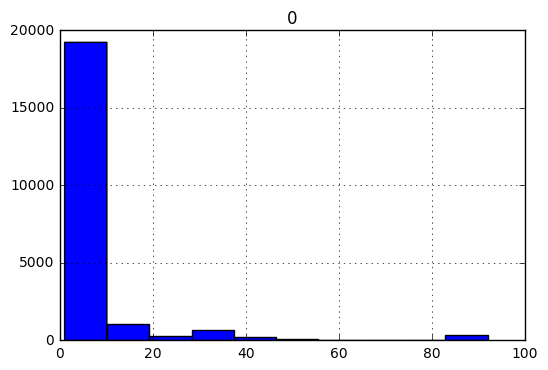

In [196]:
pd.DataFrame([len(v) for k, v in test_predictions.items()]).hist()

In [204]:
np.max([len(v) for k, v in train_predictions.items()])

92

In [199]:
len([[k, v] for k, v in train_predictions.items() if len(v) < 2])

22621

In [35]:
%%time
# Additionally, let's calculate the percentage of session time spent by every site in session
site_times = calc_site_times_portions(train_data, test_data)

CPU times: user 1min 50s, sys: 404 ms, total: 1min 51s
Wall time: 2min 15s


In [170]:
# Convert site times to sparse format
site_times_sparse = site_times_to_sparse(site_times)
train_site_times_sparse = site_times_sparse[:len(train_data)]
test_site_times_sparse = site_times_sparse[len(train_data):]
site_times_sparse

<150485x24052 sparse matrix of type '<type 'numpy.float64'>'
	with 546037 stored elements in Compressed Sparse Row format>

In [171]:
train_test_df = pd.concat([train_data, test_data])
train_index_full = list(train_data.index)
session_length = 10
train_index_dup = list(train_data[train_data.duplicated(subset=['site' + str(c) for \
                                c in range(1,session_length+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]+["target"]].index)
test_index_full = list(test_data.index)
test_index_dup = list(test_data[test_data.duplicated(subset=['site' + str(c) for \
                                c in range(1,session_length+1)], keep=False)]\
                       [['site' + str(c) for c in range(1,10+1)]].index)
train_duplicates_mask = np.transpose([np.in1d(train_index_full, train_index_dup).astype(int)])
test_duplicates_mask = np.transpose([np.in1d(test_index_full, test_index_dup).astype(int)])

y = train_data["target"]

train_test_df_sites = train_test_df[['site' + str(c) for c in range(1,10+1)]].fillna(0).astype('int')
train_test_df_sites_array = [" ".join(["s_"+str(s) for s in train_test_df_sites.as_matrix()[i] if int(s) != 0]) \
                                                              for i in range(train_test_df_sites.shape[0])]

tfidf = TfidfVectorizer(analyzer=str.split, \
                        max_df=0.9, ngram_range=(1,3),  norm=u'l1').fit(train_test_df_sites_array) 
X_train_test_sparse = tfidf.transform(train_test_df_sites_array)
#X_train_test_sparse = NMF(n_components=10000).fit_transform(X_train_test_sparse)

X_train_sparse = X_train_test_sparse[:len(train_data)]
X_test_sparse = X_train_test_sparse[len(train_data):]

class_encoder = LabelEncoder().fit(y.astype('str'))
y_for_vw = class_encoder.transform(y.astype('str')) + 1

sites_columns_num = X_train_test_sparse.shape[1]
inv_vocabulary = {v: int(re.search("s_(\d+)$", k).group(1)) for k, v in tfidf.vocabulary_.iteritems()}



In [145]:
class_encoder.transform(np.array(["380"])) +1

array([438])

In [172]:
for r, users in test_predictions.items():
    list_users = list(users)
    newc = class_encoder.transform(np.array(list_users).astype('str')) + 1
    test_predictions[r] = newc
    
for r, users in train_predictions.items():
    list_users = list(users)
    newc = class_encoder.transform(np.array(list_users).astype('str')) + 1
    train_predictions[r] = newc

In [173]:
%%time
#X_train_sparse, X_test_sparse, y, y_for_vw, sites_columns_num, class_encoder, tfidf, \
                                          #train_duplicates_mask, test_duplicates_mask = \
    #sites_to_sparse_tfidf(train_data, test_data, "target", 10, label_encoder=LabelEncoder())

mycolumns = [label for label in test_data[range(20, test_data.shape[1])]]

train_features, test_features = features_to_sparse(train_data, test_data, mycolumns)

X_train_sparse, X_test_sparse = combine_sites_features_sparse(X_train_sparse, train_features, \
                                                             X_test_sparse, test_features, \
                                                              train_duplicates_mask, test_duplicates_mask,
                                                              train_site_times_sparse, test_site_times_sparse, \
                                                             train_site_sequence, test_site_sequence)

#X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, stratify=y_for_vw)

CPU times: user 5.66 s, sys: 204 ms, total: 5.86 s
Wall time: 7.53 s


In [174]:
%%time
#train_part_vw = sparse_matrix_to_vw(X_train, sites_columns_num, inv_vocabulary, y_train)
#valid_vw = sparse_matrix_to_vw(X_valid, sites_columns_num, inv_vocabulary, y_valid)
train_vw = sparse_matrix_to_vw(X_train_sparse, sites_columns_num, inv_vocabulary, y_for_vw, \
                               mark_duplicates=False, csoaa=True, predictions=train_predictions)
test_vw = sparse_matrix_to_vw(X_test_sparse, sites_columns_num, inv_vocabulary, \
                              mark_duplicates=False, csoaa=True, predictions=test_predictions)

CPU times: user 9min 33s, sys: 1.1 s, total: 9min 34s
Wall time: 13min 25s


In [175]:
len(train_data), len(test_data)

(109308, 41177)

In [176]:
for k in test_vw.keys():
    print k, len(test_vw[k])

youtube_portion 2465
site_longest_time 41177
top30_portion 30358
sequence 41177
sitetimes 40316
unique_site 41177
start_hour 41177
prediction 7916
session_timespan 39262
day_of_week 41177
bot30_portion 16336
fb_portion 6490
sites 41177
daytime 41177


In [177]:
for k in train_vw.keys():
    print k, len(train_vw[k])

youtube_portion 6036
site_longest_time 109308
top30_portion 77133
sequence 109308
sitetimes 107456
unique_site 109308
start_hour 109308
prediction 22621
session_timespan 107183
day_of_week 109308
bot30_portion 41661
fb_portion 14226
sites 109308
daytime 109308


# Handler and Folder

In [178]:
folder = 'vw/'
handler = '_idf_w8_csoaa'

keys = ['day_of_week', 'daytime', 'prediction', 'start_hour', 'youtube_portion', 'fb_portion', 'sitetimes', 'sequence']

#vw_to_file(train_part_vw["sites"], folder+'train_part'+handler+'.vw', features={x:train_part_vw[x] for x in keys}, quiet=False)
#vw_to_file(valid_vw["sites"], folder+'valid'+handler+'.vw', features={x:valid_vw[x] for x in keys}, quiet=False)
vw_to_file(train_vw["sites"], folder+'train'+handler+'.vw.temp', features={x:train_vw[x] for x in keys}, quiet=False)
vw_to_file(test_vw["sites"], folder+'test'+handler+'.vw', features={x:test_vw[x] for x in keys}, quiet=False)

Features: ['youtube_portion', 'sequence', 'sitetimes', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']
Features: ['youtube_portion', 'sequence', 'sitetimes', 'fb_portion', 'start_hour', 'prediction', 'daytime', 'day_of_week']


In [179]:
!cat {folder}'train'{handler}.vw.temp | shuf > {folder}'train'{handler}.vw

In [180]:
!cat {folder}train{handler}.vw | grep -Po "((?<= )\d+(?=:0 )|^\d+(?=:0))" > {folder}y_train.csv

In [20]:
f = open(folder+'train_part'+handler+'.vw')
train_part_file = f.readlines()
f.close()

f = open(folder+'train'+handler+'.vw')
train_file = f.readlines()
f.close()

f = open(folder+'valid'+handler+'.vw')
valid_file = f.readlines()
f.close()

f = open(folder+'test'+handler+'.vw')
test_file = f.readlines()
f.close()

In [21]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

%%time
model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, decay_learning_rate=0.8097261737051064, random_seed=7, \
           initial_t=4.617634843743026e-05, l=0.9037695975303308, power_t=0.5, l2=3.022731250666471e-11, \
           loss_function='logistic', l1=1.2144958188964683e-11, cubic="sbc", sort_features=True, q="sd", noconstant=True)

c_scores = cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3)
print c_scores, np.mean(c_scores)

In [85]:
%%time
# L1 regularization
!vw --oaa=550 -d kaggle_data/train_part{handler}.vw \
-f kaggle_data/features{handler}.model -b 26 -c \
--passes=100 --decay_learning_rate 0.7 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --loss_function='logistic' --l1 1e-11 \
-q "sd" --cubic="sbc" --stage_poly --batch_sz 10627 --batch_sz_no_doubling --ignore "i"

creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
ignoring namespaces beginning with: i 
using l1 regularization = 1e-11
final_regressor = kaggle_data/features_idf_w8.model
Num weight bits = 26
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 0.7
using cache_file = kaggle_data/train_part_idf_w8.vw.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      457        1       17
1.000000 1.000000            2            2.0      158      457       16
1.000000 1.000000            4            4.0      336       53       16
1.000000 1.000000            8            8.0      379      128       10
1.000000 1.000000           16           16.0       69      128       13
1.000000 1.000000           32           32.0      234

In [78]:
%%time
# L2 Regularization after L1
!vw --oaa=550 -d kaggle_data/train_part{handler}.vw --passes=20 \
-f kaggle_data/initial_model{handler}.vw -b 26 -c -k \
--cubic="sbc" --sort_features -q "bs" \
--stage_poly --batch_sz 20853 --batch_sz_no_doubling --loss_function='logistic'

creating quadratic features for pairs: bs 
creating cubic features for triples: sbc 
ignoring namespaces beginning with: i 
final_regressor = kaggle_data/initial_model_idf_w10.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = kaggle_data/train_part_idf_w10.vw.cache
Reading datafile = kaggle_data/train_part_idf_w10.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      457        1       17
1.000000 1.000000            2            2.0      158      457       16
1.000000 1.000000            4            4.0      336       53       16
1.000000 1.000000            8            8.0      379      457       10
1.000000 1.000000           16           16.0       69      128       13
1.000000 1.000000           32           32.0      234      369       16
0.984375 0.96

In [ ]:
--ignore "d" --ignore "b" --ignore "i" --ignore "f" --ignore "c" --ignore "j"

In [171]:
!vw --oaa 550 -d {folder}train_part{handler}.vw \
-f {folder}initial_model{handler}.model --passes 20 --random_seed 7 -c -k --learning_rate=0.45 \
--decay_learning_rate 0.9 --bit_precision 28 --keep "s"

using namespaces beginning with: s 
final_regressor = kaggle_data/initial_model_idf_w8.model
Num weight bits = 28
learning rate = 0.45
initial_t = 0
power_t = 0.5
decay_learning_rate = 0.9
creating cache_file = kaggle_data/train_part_idf_w8.vw.cache
Reading datafile = kaggle_data/train_part_idf_w8.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      473        1        6
1.000000 1.000000            2            2.0      422      473        7
1.000000 1.000000            4            4.0      391      473        3
1.000000 1.000000            8            8.0      149      214        3
1.000000 1.000000           17           16.3      233      150       10
1.000000 1.000000           35           32.9      269      473        7
1.000000 1.000000           71           66.8      317      214        6
0.962687 0.925595        

In [103]:
!cat {folder}train{handler}.vw | wc -l

109308


In [ ]:
--decay_learning_rate 0.9 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --l1 1e-11 --l2 1e-11 \
-q "sc" --cubic="sbc" --stage_poly --batch_sz {len(train_data)/6} --batch_sz_no_doubling \
--keep "s" --keep "b" --keep "c" --keep "d" --keep "q" \
--holdout_period 5

In [181]:
%%time
!vw --csoaa=550 -d {folder}train{handler}.vw \
-f {folder}initial_model{handler}.model -b 29 -c -k \
--passes=30 \
--decay_learning_rate 0.9 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --l1 1e-15 --l2 1e-15 \
--keep "s" --keep "b" --keep "c" --keep "d" --keep "k" \
--holdout_period 5

using namespaces beginning with: s b c d k 
using l1 regularization = 1e-15
using l2 regularization = 1e-15
final_regressor = vw/initial_model_idf_w8_csoaa.model
Num weight bits = 29
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 0.9
creating cache_file = vw/train_idf_w8_csoaa.vw.cache
Reading datafile = vw/train_idf_w8_csoaa.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0    known       57       16
1.000000 1.000000            2            2.0    known       18       16
0.750000 0.500000            4            4.0    known        1        9
0.625000 0.500000            8            8.0    known       34       23
0.812500 1.000000           16           16.0    known        5       19
0.812500 0.812500           32           32.0    known      150       22
0.765625 0.718750           64  

average loss = 0.418117 h

In [187]:
%%time
!vw -i {folder}initial_model{handler}.model  -t -d {folder}test{handler}.vw \
-p {folder}vw_test_pred{handler}.csv

only testing
predictions = vw/vw_test_pred_idf_w8_csoaa.csv
Num weight bits = 29
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = vw/test_idf_w8_csoaa.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown      461        7
0.000000 0.000000            2            2.0  unknown      517       26
0.000000 0.000000            4            4.0  unknown      168        9
0.000000 0.000000            8            8.0  unknown      444       28
0.000000 0.000000           16           16.0  unknown       66       19
0.000000 0.000000           32           32.0  unknown      368       27
0.000000 0.000000           64           64.0  unknown      150       25
0.000000 0.000000          128          128.0  unknown      426       32
0.000000 0.000000          256          256.0  unknown      526    

In [188]:
vw_pred = pd.read_csv(folder+'vw_test_pred'+handler+'.csv', header=None)
vw_subm = class_encoder.inverse_transform(vw_pred.as_matrix()-1)

In [189]:
write_to_submission_file(vw_subm,
                         folder+'novw_submission'+handler+'.csv')

In [192]:
!gsutil ls gs://smartandnimble/identifyme/novw_submission{handler}.csv

gs://smartandnimble/identifyme/novw_submission_idf_w8_csoaa.csv


In [191]:
!gsutil cp {folder}novw_submission{handler}.csv gs://smartandnimble/identifyme

Copying file://vw/novw_submission_idf_w8_csoaa.csv [Content-Type=text/csv]...
/ [1 files][419.5 KiB/419.5 KiB]                                                
Operation completed over 1 objects/419.5 KiB.                                    


In [184]:
y_valid = pd.read_csv(folder+'y_train.csv', header=None)

In [130]:
len(y_valid)

109308

In [185]:
vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.68795513594613389

In [186]:
test_predictions

{0: array([249, 317, 491, 166, 167, 168, 328, 126,  39,  17, 327, 471, 330,
        407, 128, 289, 179, 337,  24, 386,  76,  23, 506, 314, 230, 392,
        110, 439, 461, 340, 367, 487]),
 1: array([517]),
 3: array([317, 168, 224, 138]),
 4: array([486]),
 5: array([356, 482, 423, 518, 320, 324, 372, 325, 147, 326,  98, 425, 279,
         99,  56, 359, 427,  18, 525, 379, 232, 477, 283, 233, 102, 424,
        235,  68, 337, 431, 533, 294, 106, 434,  27, 193,  12, 109, 485,
        299, 438,  31, 534, 176, 346,  74, 258, 202,  35, 203, 354,  38,
        404, 173, 500, 545, 172, 211, 124, 212, 455, 308, 458, 360, 459,
        132, 134, 271, 375, 462]),
 6: array([417, 419, 420, 297,  92, 100,  54, 467, 141, 142, 469, 522, 277,
        327, 187, 373,  97,  14, 328,  56, 377, 471, 476, 347,  20,  61,
        189, 190, 508, 515, 481, 290, 156, 337,  24, 530,  64, 242,   3,
        223, 246, 196, 393, 336, 111, 487, 343, 113, 251, 386, 218, 349,
        507,  34, 475, 402, 491, 259, 204, 2

valid: 0.56661482633488858 -q "sd" -q "sb" --cubic="sbc"

### Submission

In [202]:
trainvw = open(folder+'train'+handler+'.vw').readlines()
np.random.shuffle(trainvw)
with open(folder+'train'+handler+'.vw', "wb") as f:
    for item in trainvw:
        f.write("%s" % item)

In [203]:
%%time
!vw --oaa=550 -d {folder}train{handler}.vw --passes=30 \
-f {folder}initial_model{handler}.model -b 26 -c \
--decay_learning_rate 0.9 --initial_t 0.002337045080352835 -l 0.8416950450219994 \
--power_t 0.5 --loss_function='logistic' --l1 1e-11 --l2 1e-11 \
-q "sd" --cubic="sbc" --stage_poly --batch_sz {len(train_file)/6} --batch_sz_no_doubling


creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
using l1 regularization = 1e-11
using l2 regularization = 1e-11
final_regressor = kaggle_data/initial_model_idf_w7.model
Num weight bits = 26
learning rate = 0.841695
initial_t = 0.00233705
power_t = 0.5
decay_learning_rate = 0.9
creating cache_file = kaggle_data/train_idf_w7.vw.cache
Reading datafile = kaggle_data/train_idf_w7.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      377        1       16
1.000000 1.000000            2            2.0      521      377       30
1.000000 1.000000            4            4.0      387      377       31
1.000000 1.000000            8            8.0      240      347       34
1.000000 1.000000           16           16.0      318      291       29
1.000000 1.000000           32           32.0      352 

In [206]:
%%time
#Prediction on VALID
!vw -i {folder}initial_model{handler}.model  -t -d {folder}valid{handler}.vw \
-p {folder}vw_valid_pred{handler}.csv --quiet

CPU times: user 224 ms, sys: 56 ms, total: 280 ms
Wall time: 12.9 s


In [207]:
vw_valid_pred = pd.read_csv(folder+'vw_valid_pred'+handler+'.csv', header=None)
accuracy_score(y_valid, vw_valid_pred.values)

0.84135093710505793

In [208]:
%%time
# Prediction on TEST!
!vw -i {folder}initial_model{handler}.model -t -d {folder}test{handler}.vw \
-p {folder}vw_test_pred{handler}.csv


creating quadratic features for pairs: sd 
creating cubic features for triples: sbc 
only testing
predictions = kaggle_data/vw_test_pred_idf_w7.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = kaggle_data/test_idf_w7.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown      487        8
1.000000 1.000000            2            2.0  unknown      517       28
1.000000 1.000000            4            4.0  unknown      168        8
1.000000 1.000000            8            8.0  unknown       24       34
1.000000 1.000000           16           16.0  unknown      328       16
1.000000 1.000000           32           32.0  unknown      460       31
1.000000 1.000000           64           64.0  unknown      150       31
1.000000 1.000000          128          128.0  un

In [209]:
vw_pred = pd.read_csv(folder+'vw_test_pred'+handler+'.csv', header=None)
vw_subm = class_encoder.inverse_transform(vw_pred-1)

In [210]:
write_to_submission_file(vw_subm,
                         folder+'23vw_submission'+handler+'.csv')

Score: 0.57276

# Hyperopt

In [138]:
%%time
def hyperopt_train_test(params):
    with open(folder+'train_part'+handler+'.vw') as f:
        train_part_file = f.readlines()
    
    with open(folder+'valid'+handler+'.vw') as f:
        valid_file = f.readlines()
    
    clas_type = params["type"]
    del params["type"]
    
    if clas_type == "ect":
        model = VW(ect=550, passes=30, b=26, convert_to_vw=False, sort_features=True, **params)
    else:
        model = VW(oaa=550, passes=30, b=26, convert_to_vw=False, sort_features=True, **params)
    
    #skf = StratifiedKFold(n_splits=3, shuffle=True)
    model.fit(train_part_file)
    accuracy = accuracy_score(y_valid, model.predict(valid_file))
    return accuracy
    #return cross_val_score(model, X=train_part_file, y=y_train, cv=skf, scoring=make_scorer(accuracy_score), n_jobs=3).mean()

space4knn = {
    'type': hp.choice('type', ['oaa', 'ect']),
    'l': hp.loguniform('l', -5, 3),
    'initial_t': hp.loguniform('initial_t', -10, 1),
    'power_t': hp.choice('power_t', [0.5, 1]),
    'decay_learning_rate': hp.uniform('decay_learning_rate', 0.001, 1),
    'l2': hp.loguniform('l2', -20, -9),
    'l1': hp.loguniform('l1', -20, -9),
    'loss_function': hp.choice('loss_function', ["logistic", "hinge", "squared"]),
    'ftrl': hp.choice('ftrl', [True, False]),
    'noconstant': hp.choice('noconstant', [True, False]),
    'cubic': hp.choice('cubic', ['sbc', 'ibc']),
    'q': hp.choice('q', ["sb", "sc", "sd", "si"])
}

def f(params):
    print "Testing with params:"
    print params
    acc = hyperopt_train_test(params)
    print "Accuracy:", acc, "\n"
    return {'loss': -acc, 'status': STATUS_OK}

trials_wide_range = Trials()
#trials_wide_range = MongoTrials('mongo://localhost:1234/mydb/jobs', exp_key='exp1')
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials_wide_range)
print 'best:'
print best

Testing with params:
{'cubic': 'sbc', 'ftrl': True, 'decay_learning_rate': 0.867574166625138, 'initial_t': 0.2776239270739265, 'l': 0.0434341264970275, 'q': 'si', 'power_t': 1, 'noconstant': True, 'l2': 5.248698547405331e-09, 'loss_function': 'squared', 'l1': 1.541908660931064e-08, 'type': 'ect'}
Accuracy: 0.412161131949 

Testing with params:
{'cubic': 'sbc', 'ftrl': True, 'decay_learning_rate': 0.4380919176573933, 'initial_t': 0.08681977356754463, 'l': 0.2790283913381128, 'q': 'sc', 'power_t': 0.5, 'noconstant': True, 'l2': 1.4656938601889154e-08, 'loss_function': 'hinge', 'l1': 2.5435275529929987e-07, 'type': 'oaa'}
Accuracy: 0.528496935322 

Testing with params:
{'cubic': 'ibc', 'ftrl': False, 'decay_learning_rate': 0.10244638809961329, 'initial_t': 1.0419999810170089, 'l': 0.07462834369874273, 'q': 'si', 'power_t': 1, 'noconstant': False, 'l2': 1.1388346589835574e-06, 'loss_function': 'squared', 'l1': 5.803833976036988e-09, 'type': 'oaa'}
Accuracy: 0.289513005824 

Testing with pa

KeyboardInterrupt: 